In [1]:
## The electrode-by-electrode and trial-by-trial correlation checks I use don't work with Staresina algo for various reasons.
## This version comments out the key lines so the Staresina algo can run
## I'm using the hamming method to select my sub+sess+elec anyway, so don't need to remove bad elecs or sessions here anyway 2021-11-18 JS

# It also loads everything at the bottom and makes the comparison figure I was looking for between Norman and Vaz filters

# steps are:
# •load typical 'hamming' and get norman_ca1_df (for comparison using 4 SD original version), butter_ca1_df and staresina_ca1_df
# •get intersect_sess_channel, which is used in the Load step
# •run each of hamming/butter/staresina with 4/6 to get the 6 plots (1st and ≥2nd for each)
# •when done with all 6 can load the comparison plot
# •both interaction and simpler trial_type comparison are below it


In [2]:
# creating version for Ebrahim that hopefully works. JJS 2023-02-28

In [3]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/johnModules')
from brain_labels import HPC_labels, ENT_labels, PHC_labels, temporal_lobe_labels,\
                         MFG_labels, IFG_labels, nonHPC_MTL_labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

df = get_data_index("r1") # all RAM subjects
exp = 'FR1' # 'FR1' 'catFR1' 'RepFR1'

/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:526: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):


In [2]:
# sub lists I've been using to explore FR1 

# subs = ['R1010J'] #'R1385E'] # ['R1065J'] #
# subs = ['R1002P','R1003P','R1006P','R1010J','R1112M','R1163T'] # initial 6 for hippocampus

# subs = subs+['R1001P','R1092J','R1151E','R1320D'] # additional subs with issues that I resolved with various RR and corr thresholds
# subs = ['R1112M','R1018P','R1020J','R1022J','R1023J','R1026D','R1027J'] # 7 with entorhinal
# subs = ['R1010J','R1112M'] # original 2 # R1108J beatiful catFR1 data; R1065J magical subject (like with FR1)
# subs = ['R1112M','R1163T'] # subjects with FR1 and catFR1. SRs of 1000 and 500 tho
# subs = ['R1151E'] # all channels X sessions get removed but 3 after 60/180 hz line removal
# these should all be worked out now. See SWR FR1 problem sessions PPT on Box for details of each
# subs = ['R1299T','R1332M','R1397D','R1349T','R1339D','R1337E','R1275D','R1151E','R1123C','R1120E','R1045E'] # final surrounding_recall problem subs after looking at huge raster!
# subs = ['R1308T','R1338T','R1358T'] # these guys had weird SRs and some loading problems when I went to whole_retrieval analysis...fixed with rounding
# subs = ['R1023J','R1101T','R1148P','R1368T','R1323T','R1334T'] # single session subs with memory allocation errors in ClusterRun
# subs = ['R1006P','R1010J','R1030J','R1032D','R1049J','R1051J','R1052E','R1054J','R1093J','R1098D','R1104D','R1108J','R1111M',
#         'R1115T','R1118N','R1124J','R1207J','R1230J','R1316T','R1329T','R1323T','R1337E','R1367D'] # subs that didn't load on 2020-07-04 encoding run
# subs = ['R1368T','R1461T','R1463E'] # subs with particularly low localization.pair matches in pairs...see Excel in loading info on Box for details
# subs = ['R1433E','R1355T','R1367D','R1368T'] # subs with "ca3" or "dg"
# subs = ['R1001P'] # subject with over 8000 FR1 trials X electrodes
# bad_subs = ['R1433E','R1051J'] # no electrode cats
# subs = ['R1379E','R1385E','R1387E','R1394E','R1402E'] # partial beep subs
# subs = ['R1379E','R1402E','R1396T','R1395M','R1415T','R1389J','R1404E']  # test subs for eeg offset correction
# subs = ['R1054J','R1345D','R1048E','R1328E','R1308T', # first 2 are sr ≥ 1000. 3rd is 500 Hz.
#         'R1137E','R1136N','R1094T','R1122E','R1385E', # nice example FR1 subs used in Fig. 2
#         'R1405E','R1486J','R1501J'] # adding in 3 catFR only patients that will go into Fig. 4
# subs = ['R1120E','R1349T','R1397D','R1332M','R1299T'] # FR1 patients with electrode search ranges limited per SWR problem sessions doc on Box
# subs = ['R1269E','R1328E','R1367D','R1397D','R1405E','R1405E','R1447M','R1469D'] # catFR1 patients with electrode search changes limited
# subs = ['R1528E'] #['R1501J'] #['R1587J'] ['R1564J']
# subs = ['R1492J','R1525J']
# subs = ['R1030J','R1035M'] # MFG subs
subs = ['R1108J']

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp) & (df.session==1)] # single session
# sub_df = df[(df.experiment == exp) & (df.session == 0)] # all FR subs 
sub_df = sub_df[2:3]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
599,NaN,protocols/r1/subjects/R1108J/experiments/FR1/s...,protocols/r1/subjects/R1108J/localizations/0/m...,FR1,conversion,0,protocols/r1/subjects/R1108J/experiments/FR1/s...,1,NaN,2,protocols/r1/subjects/R1108J/localizations/0/m...,NaN,2,R1108J,R1108J_1,NaN,protocols/r1/subjects/R1108J/experiments/FR1/s...


In [3]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
if exp == 'FR1':
    exp_df = exp_df[
                    ((df.subject!='R1015J') | (df.session!=0)) & 
                    ((df.subject!='R1063C') | (df.session!=1)) & 
                    ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                    ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1120E') | (df.session!=0)) &
                    ((df.subject!='R1122E') | (df.session!=2)) &
                    ((df.subject!='R1154D') | (df.session!=0)) &
                    ((df.subject!='R1186P') | (df.session!=0)) &
                    ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                    ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1277J') | (df.session!=0)) &
                    ((df.subject!='R1413D') | (df.session!=0)) & 
                    ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                    ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                    ((df.subject!='R1275D') | (df.session!=3))  # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
    #                 (df.subject!='R1065J') # sub with 9000 trials
                   ] 
elif exp == 'catFR1': 
    exp_df = exp_df[
                    ((df.subject!='R1044J') | (df.session!=0)) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1491T') | (~df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1486J') | (~df.session.isin([4,5,6,7]))) & # repeated data...will be removed at some point... @@
                    ((df.subject!='R1501J') | (~df.session.isin([0,1,2,3,4,5]))) & # these weren't catFR1 (and they don't load right anyway)
                    ((df.subject!='R1235E') | (df.session!=0)) & # split EEG filenames error...documented on Asana
                    ((df.subject!='R1310J') | (df.session!=1)) & # session 1 is just a repeat of session 0
                    ((df.subject!='R1239E') | (df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
    ]
elif exp == 'RepFR1':
    exp_df = exp_df[
                    (df.subject!='R1564J') # clearly something wrong with these EEG when looking at ripple raster
                    ]
exp_df.shape
# exp_df = exp_df[257:] # for catFR1 this is R1385E-onwwards
# exp_df = exp_df[472:] # for FR1 this is R1385E-onwwards
# exp_df = exp_df[4:7]
exp_df

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(567, 17)

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
0,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,0,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
1,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,1,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
9,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,0,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
10,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,1,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
17,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,0,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539,NaN,protocols/r1/subjects/R1565T/experiments/FR1/s...,protocols/r1/subjects/R1565T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1565T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1565T/localizations/0/m...,NaN,0,R1565T,R1565T,1.0,protocols/r1/subjects/R1565T/experiments/FR1/s...
2549,NaN,protocols/r1/subjects/R1569T/experiments/FR1/s...,protocols/r1/subjects/R1569T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1569T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1569T/localizations/0/m...,NaN,0,R1569T,R1569T,1.0,protocols/r1/subjects/R1569T/experiments/FR1/s...
2554,NaN,protocols/r1/subjects/R1571T/experiments/FR1/s...,protocols/r1/subjects/R1571T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1571T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1571T/localizations/0/m...,NaN,0,R1571T,R1571T,1.0,protocols/r1/subjects/R1571T/experiments/FR1/s...
2558,NaN,protocols/r1/subjects/R1572T/experiments/FR1/s...,protocols/r1/subjects/R1572T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1572T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1572T/localizations/0/m...,NaN,0,R1572T,R1572T,1.0,protocols/r1/subjects/R1572T/experiments/FR1/s...


In [6]:
# Want to try and find those files that haven't been made yet (due to memory limits) and re-run only those
# **only an issue with encoding or whole_retrieval due to their large EEG matrices**

### params that clusterRun used
selected_period = 'surrounding_recall' # surrounding_recall # whole_retrieval # encoding 
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC 
remove_soz_ictal = 0
filter_type = 'hamming' # butter/hamming/staresina
extra = '-ORIGNORMAN'
recall_type_switch = 0
recall_minimum = 2000
###
# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

rerun_mask = []

for i,row in enumerate(exp_df.itertuples()):
    sub = row.subject; session = row.session; exp = row.experiment

    path_name = '/scratch/john/SWR_scratch/'+subfolder
    fn = os.path.join(path_name,
        'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+'_'+soz_label+'_'+filter_type+extra+'.p') 
    try:
        with open(fn,'rb') as f:
            dat = pickle.load(f)
    except:
        rerun_mask.append(i)
        
# view the rerun_mask
len(rerun_mask)
rerun_df = exp_df.iloc[rerun_mask]
rerun_df

17

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
230,NaN,protocols/r1/subjects/R1045E/experiments/FR1/s...,protocols/r1/subjects/R1045E/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1045E/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1045E/localizations/0/m...,NaN,0,R1045E,R1045E,NaN,protocols/r1/subjects/R1045E/experiments/FR1/s...
341,NaN,protocols/r1/subjects/R1061T/experiments/FR1/s...,protocols/r1/subjects/R1061T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1061T/experiments/FR1/s...,0,NaN,3,protocols/r1/subjects/R1061T/localizations/0/m...,NaN,3,R1061T,R1061T,NaN,protocols/r1/subjects/R1061T/experiments/FR1/s...
661,NaN,protocols/r1/subjects/R1113T/experiments/FR1/s...,protocols/r1/subjects/R1113T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1113T/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1113T/localizations/0/m...,NaN,1,R1113T,R1113T,NaN,protocols/r1/subjects/R1113T/experiments/FR1/s...
662,NaN,protocols/r1/subjects/R1113T/experiments/FR1/s...,protocols/r1/subjects/R1113T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1113T/experiments/FR1/s...,0,NaN,2,protocols/r1/subjects/R1113T/localizations/0/m...,NaN,2,R1113T,R1113T,NaN,protocols/r1/subjects/R1113T/experiments/FR1/s...
835,NaN,protocols/r1/subjects/R1147P/experiments/FR1/s...,protocols/r1/subjects/R1147P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1147P/experiments/FR1/s...,0,NaN,3,protocols/r1/subjects/R1147P/localizations/0/m...,NaN,1,R1147P,R1147P,2.0,protocols/r1/subjects/R1147P/experiments/FR1/s...
857,NaN,protocols/r1/subjects/R1153T/experiments/FR1/s...,protocols/r1/subjects/R1153T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1153T/experiments/FR1/s...,0,NaN,3,protocols/r1/subjects/R1153T/localizations/0/m...,NaN,1,R1153T,R1153T,1.0,protocols/r1/subjects/R1153T/experiments/FR1/s...
935,NaN,protocols/r1/subjects/R1164E/experiments/FR1/s...,protocols/r1/subjects/R1164E/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1164E/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1164E/localizations/0/m...,NaN,0,R1164E,R1164E,2.0,protocols/r1/subjects/R1164E/experiments/FR1/s...
1378,NaN,protocols/r1/subjects/R1243T/experiments/FR1/s...,protocols/r1/subjects/R1243T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1243T/experiments/FR1/s...,0,NaN,3,protocols/r1/subjects/R1243T/localizations/0/m...,NaN,3,R1243T,R1243T,NaN,protocols/r1/subjects/R1243T/experiments/FR1/s...
1751,NaN,protocols/r1/subjects/R1339D/experiments/FR1/s...,protocols/r1/subjects/R1339D/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1339D/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1339D/localizations/0/m...,NaN,0,R1339D,R1339D,3.1,protocols/r1/subjects/R1339D/experiments/FR1/s...
1763,NaN,protocols/r1/subjects/R1342M/experiments/FR1/s...,protocols/r1/subjects/R1342M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1342M/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1342M/localizations/0/m...,NaN,1,R1342M,R1342M,3.1,protocols/r1/subjects/R1342M/experiments/FR1/s...


## Load CLUSTER data

## ONLY LOAD SUBJECTS, SESSIONS, AND CHANNELS that were loaded using Norman algo (got via original SWRanalysis)

In [8]:
# load df from hamming run so can take only trials that loaded from it

# # save df code for each detector type
# norman_ca1_df = pd.DataFrame(data={'session':session_name_array,'subject':subject_name_array,'channel_num':channel_nums_array})
# norman_ca1_df.to_csv('/home1/john/SWR/compiled/norman_ca1_df.csv') 

hamming_ca1_df = pd.read_csv('/home1/john/SWR/compiled/norman_ca1_df.csv') #hamming_ca1_df.csv') 
hamming_ca1_df = hamming_ca1_df.drop_duplicates()
butter_ca1_df = pd.read_csv('/home1/john/SWR/compiled/butter_ca1_df.csv') 
butter_ca1_df = butter_ca1_df.drop_duplicates()
staresina_ca1_df = pd.read_csv('/home1/john/SWR/compiled/staresina_ca1_df.csv') 
staresina_ca1_df = staresina_ca1_df.drop_duplicates()

hamming_sess_channel = np.unique(hamming_ca1_df.session.values+hamming_ca1_df.channel_num.astype(str))
butter_sess_channel = np.unique(butter_ca1_df.session.values+butter_ca1_df.channel_num.astype(str))
staresina_sess_channel = np.unique(staresina_ca1_df.session.values+staresina_ca1_df.channel_num.astype(str))

# this has a unique label for a given sub-sess-channel, so can select properly for each dataset
intersect_sess_channel = set.intersection(*map(set,[hamming_sess_channel,butter_sess_channel,staresina_sess_channel]))


In [9]:
## Now to load data from cluster, have to go through and append across sessions


selected_period = 'surrounding_recall'
# 'surrounding_recall': aligned to time of free recall 
# 'whole_retrieval': aligned to beginning of retrieval period (beep_off)
# 'encoding': aligned to word_on
# 'whole_encoding': aligned to 1st word of each encoding period and ends 29.7 s later (average time for 12 words to be shown)
#               NOTE: this analysis is in SWRanalysis-encoding.ipynb now
# 'math': aligned to math problem on
# 'math_retrieval': aligned to math problem key-in time

recall_type_switch = 4
    # (1 and 3 are basically opposites...those with a subsequent recall and those without)
    # 0: Original analysis taking only recalls without a recall in 2 s IRI before them
    # 1: Take these same recalls, but keep only those WITH a recall within 2 s after they occur 
    # 2: test condition where we look at second recalls within IRI ONLY (there is an initial recall in 2 s before current recall)
    # 3: isolatead recalls with no other recalls +/- RECALL_MINIMUM s
    # 4: only first recall of every retrieval period
    # 5: take only those recalls that come second in retrieval period within 2 s of first retrieval
    # 6: take only NOT first recall of every retrieval period (opposite of 4)
    # 7: take only NOT first recall AND ISOLATED trials (this should REALLY maximize SWR bump)
    # 8: take only 2nd recalls
    # 10: same as 0 but with no IRI (mostly just to see number of recalls)
recall_minimum = 2000 # used if recall_type_switch = 3
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC # TEMPORALLOBE # IFG # MFG
remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###
filter_type = 'hamming' # butter/hamming/staresina
sub_selection = 'whole' # 'second_half', 'whole' ,'first_half'
                              # analyze first 40%, remaining 60% of data, or whole? 
                              # works for FR1 and catFR1
extra = '-ORIGNORMAN' 
# -ORIGNORMAN is the 4SD Norman algo 
# -NOCUTOFFS is for butter and staresina (since Norman takes care of the trial selection don't cut off channels/sessions with params)
###

# get strings for path name for save and loading cluster data
if recall_type_switch in [0,4,6,8]:
    # for these I'm using all trials, but selecting for which recall after the fact
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,0,selected_period,recall_minimum)
else: # these others I haven't set up indexing (see >line 100 in this cell)
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
ripple_array = []; 
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []; fr_array = []
list_num_key = []

serialpos_array = []; list_recall_num_array = []; # ~~~
rectime_array = []; recall_before_intrusion_array = []
recall_position_array = []; session_events = pd.DataFrame()

electrode_labels = []; channel_coords = []; channel_nums = []

analysis_df = getSplitDF(exp_df,sub_selection,exp)

for row in analysis_df.itertuples(): #analysis_df.itertuples(): #sub_df.itertuples():  
    try:
        sub = row.subject; session = row.session; exp = row.experiment
        
#         subfolder = 'IRIonly 2022-03-04 zscore events only HFA (and all other old files)'

        path_name = '/scratch/john/SWR_scratch/'+subfolder
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                          '_'+soz_label+'_'+filter_type+extra+'.p')
        with open(fn,'rb') as f:
            dat = pickle.load(f)

            ripple_array = superVstack(ripple_array,dat['ripple_array']) 
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.extend(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            #,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)
            if selected_period == 'whole_retrieval':
                if np.shape(dat['fr_array'])[0]!=np.shape(dat['ripple_array'])[0]:
                    print(sub+str(session))
                fr_array = superVstack(fr_array,dat['fr_array'])
            elif selected_period == 'encoding':
                serialpos_array.extend(dat['serialpos_array'])
                session_events = session_events.append(dat['session_events']) # doesn't append in place 
            elif selected_period == 'surrounding_recall': # ~~~
                serialpos_array.extend(dat['serialpos_array']); list_recall_num_array.extend(dat['list_recall_num_array']); # ~~
                rectime_array.extend(dat['rectime_array']); recall_before_intrusion_array.extend(dat['recall_before_intrusion_array'])
                recall_position_array.extend(dat['recall_position_array'])
                               
            elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
                rectime_array.extend(dat['rectime_array'])
                recall_position_array.extend(dat['recall_position_array']); list_recall_num_array.extend(dat['list_recall_num_array'])
            elif selected_period == 'whole_encoding':
                serialpos_array.extend(dat['serialpos_array']); recall_position_array.extend(dat['recall_position_array'])
                list_recall_num_array.extend(dat['list_recall_num_array']); 

            electrode_labels.extend(dat['electrode_labels'])
            channel_coords.extend(dat['channel_coords'])
            channel_nums.extend(dat['channel_nums'])
            list_num_key.extend(dat['list_num_key'])
            
    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')  
print('**Done reading data**')
        
## loading *all* the recalls with 0, but if it's 4 or 6 load just those trials

# trying new method of loading...translate these to ripple_array length dependent on recall_type_switch 
# (this way I can always load from recall_type_switch = 0)

subject_name_array,session_name_array,electrode_array,channel_coords_array,channel_nums_array = getSubSessPredictorsWithChannelNums(
        sub_names,sub_sess_names,trial_nums,electrode_labels,channel_coords,channel_nums)


## select only subjects/sessions/channels from hamming_df ##

load_idxs = np.zeros(len(subject_name_array))
for i_trial in range(len(subject_name_array)):
    if (session_name_array[i_trial]+str(channel_nums_array[i_trial])) in intersect_sess_channel:
        load_idxs[i_trial] = True


if selected_period == 'surrounding_recall':
    if recall_type_switch == 4:
        temp_recall_idxs = np.array(recall_position_array)==1
    elif recall_type_switch == 6:
        temp_recall_idxs = np.array(recall_position_array)>1
    elif recall_type_switch == 8:
        temp_recall_idxs = np.array(recall_position_array)==2
    else:
        temp_recall_idxs = np.array(recall_position_array)>=0
        
    # grab correct recall type *AND* trials that were in hamming_df
    temp_recall_idxs = ((temp_recall_idxs) & (load_idxs==1)) # LOAD UP INTERSECTING TRIALS HERE
        
    serialpos_array = np.array(serialpos_array)[temp_recall_idxs]
    recall_before_intrusion_array = np.array(recall_before_intrusion_array)[temp_recall_idxs]
    list_num_key = np.array(list_num_key)[temp_recall_idxs]
elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
    temp_recall_idxs = np.array(recall_position_array)>=0 # just keep them all for math
    encoded_word_key_array.extend(dat['encoded_word_key_array'])
elif selected_period == 'whole_encoding':
    temp_recall_idxs = np.array(list_recall_num_array)>=0 # just keep them all
elif selected_period == 'encoding':
    session_events = session_events[temp_recall_idxs]
    
subject_name_array = np.array(subject_name_array)[temp_recall_idxs]
session_name_array = np.array(session_name_array)[temp_recall_idxs]
electrode_array = np.array(electrode_array)[temp_recall_idxs]
channel_coords_array = np.array(channel_coords_array)[temp_recall_idxs]
channel_nums_array = np.array(channel_nums_array)[temp_recall_idxs]
ripple_array = np.array(ripple_array)[temp_recall_idxs]
rectime_array = np.array(rectime_array)[temp_recall_idxs]
list_recall_num_array = np.array(list_recall_num_array)[temp_recall_idxs]
recall_position_array = np.array(recall_position_array)[temp_recall_idxs]
    
print('**Done translating to ripple_array frame**!!')
print('...')
print('% of all HPC subjects for '+exp)
if exp == 'catFR1':
    len(np.unique(sub_names))/136*100 # % HPC subs for catFR1
    print('% of HPC recalls for '+exp)
    ripple_array.shape[0]/50053*100 # % recalls for catFR1
if exp == 'FR1':
    len(np.unique(sub_names))/167*100 # % HPC subs for FR1
    print('% of HPC recalls for '+exp)
    ripple_array.shape[0]/60417*100 # % recalls for FR1
    
## some info on data loaded from cluster runs ##
ripple_array.shape

region_electrode_ct = np.array(region_electrode_ct)
# print('Number of electrodes in each session: '); region_electrode_ct
print('From '+str(sum(region_electrode_ct>0))+'/'+str(len(region_electrode_ct))+' sessions with >0 '+region_name+' electrodes')
print('Total trials: '+str(int(np.sum(trial_nums))))
print('Unique sessions: '+str(len(np.unique(sub_sess_names))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')

# some info about regions 
sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))

print('Electrode regions X sessions:')
unique_names = np.unique(HPC_names)
for name in unique_names:
    num_elecs = sum(np.array([names.find(name) for names in HPC_names])>=0)
    print(str(num_elecs)+' for '+name)


[]
[]
2023-03-01_00-49-53: DF Exception: Sub: R1061T, Sess: 3, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_FR1_R1061T_3_HPC_surrounding_recall_soz_in_hamming-ORIGNORMAN.p', file: <ipython-input-9-8f48c320cc1d>, line no: 70
2023-03-01_00-49-56: DF Exception: Sub: R1113T, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_FR1_R1113T_1_HPC_surrounding_recall_soz_in_hamming-ORIGNORMAN.p', file: <ipython-input-9-8f48c320cc1d>, line no: 70
2023-03-01_00-49-56: DF Exception: Sub: R1113T, Sess: 2, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_FR1_R1113T_2_HPC_surrounding_recall_soz_in_hamming-ORIGNORMAN.p', file: <ipython-input-9-8f48c320cc1d>, line no: 70
2023-03-01_00-49-58: DF Exception: Sub: R1147P, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_FR1_R1147P_1_HPC_surrounding_recall_so

97.60479041916167

% of HPC recalls for FR1


16.669149411589455

(10071, 2000)

From 334/404 sessions with >0 HPC electrodes
Total trials: 56610
Unique sessions: 334
...from 85 patients
Number of electrodes: 230
Electrode regions X sessions:
97 for  left hippocampus
79 for  right hippocampus
140 for "ca1"
72 for "dg"
20 for "sub"
688 for ca1
332 for dg
332 for left ca1
7 for left ca2
11 for left ca3
183 for left dg
156 for left hippocampus
50 for left sub
214 for right ca1
3 for right ca3
76 for right dg
97 for right hippocampus
32 for right sub


## Get start_array and select subfield if HPC for free recalls

In [10]:
## DO YOU WANT TO SELECT A SUBFIELD or OUTPUT POSITION?? ##  

select_subfield = True   # note: if you already ran this once, have to load again from data
                          # also this is only for HPC. So set to FALSE for ENT and PHC
    
# select for subfield if HPC
if select_subfield == True:
    location_selected = 'ca1' #'dg' # 'ca3' # 'dg' 'ca1' # sub # ['ca1','dg']
        # left # right # left hippocampus # right hippocampus # hippocampus
        # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
else:
    location_selected = ''
    

### Use a task condition to select recalls?? ###
### ...will select first one that's not 0    ###
select_ordinal_position = 0              # select only recalls at given output position. 0 means it's off ##DEPRECATED
select_list_position = 0 #[1,2,3] #[12]  # select only recalls at given position from encoding list. 
                                         # 0 means it's off. Must be list
select_less_than_rectime = 0             # select only recalls < this number % 5000
select_greater_than_rectime = 0          # select only recalls ≥ this number % 5000
select_lists_with_recalls = 0 # list(np.arange(3,13)) # [1] so this would select ≥4 recalls. Must be list hence the list(arange...)
                                         # select only recalls that come from lists with number in this list
select_intrusions_next = 0               # select recalls that lead to intrusions
    
# if filter_type.find('hamming') != -1:
desired_sample_rate = 500.
# else:
#     desired_sample_rate = 1000.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate
if filter_type == 'butter':
    sr = 1000
    sr_factor = 1 # I guess this data didn't get downsampled?

print('Total electrodes loaded: '+str(len(trial_nums)))
print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print(trial_nums[0:20])
print('Trial sum = '+str(np.sum(trial_nums)))
print(HPC_names[0:20])
print('Number of sub_sess names: '+str(len(sub_sess_names)))


start_array,end_array = getStartEndArrays(ripple_array) # get start array
 
# if selected an output position
if select_ordinal_position > 0:
    if np.min(ordinal_position_array) == 0: # only update this once (so don't have to reload data from files)
        ordinal_position_array = np.array(ordinal_position_array)+1 # now 1-indexed
    selected_recalls = ordinal_position_array==select_ordinal_position
elif type(select_list_position) == list:
    selected_recalls = [sp in select_list_position for sp in serialpos_array]
elif select_intrusions_next == 1:
    selected_recalls = np.array(recall_before_intrusion_array)==True
elif select_less_than_rectime > 0:
    selected_recalls = np.array(rectime_array)<select_less_than_rectime
elif select_greater_than_rectime > 0:
    selected_recalls = np.array(rectime_array)>=select_greater_than_rectime
elif type(select_lists_with_recalls) == list:
    selected_recalls = [recall in select_lists_with_recalls for recall in list_recall_num_array]
else:
    selected_recalls = np.ones(len(start_array),dtype=bool)
    
# get locations if selected

if select_subfield == True:
    # create the full vector of location name predictors
    location_names = []
    for s in range(len(HPC_names)):
        new_trials = int(trial_nums[s])
        location_names.extend(np.tile(HPC_names[s],new_trials))  
        
    # now can get mask of trials in this location
    
    #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
    location_mask = np.zeros(len(location_names))
    for s in range(len(location_names)):
        if type(location_selected)==list:
            if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                location_mask[s] = True
        elif type(location_selected)==str:
            if location_names[s].find(location_selected)>=0:
                location_mask[s] = True
else:
    location_mask = np.ones(len(start_array))

# gotta translate this to new frame as well from idxs in load step if selected subfield
if select_subfield == True: 
    location_mask = location_mask[temp_recall_idxs] 

# combine location and sorted recalls to get new ripple array:
updated_recalls = (location_mask+selected_recalls)==2
    
# translate these predictors to vector and select recalls
start_array = start_array[updated_recalls]
end_array = end_array[updated_recalls] # used for duration calculations
subject_name_array = np.array(subject_name_array)[updated_recalls]
session_name_array = np.array(session_name_array)[updated_recalls]
electrode_array = np.array(electrode_array)[updated_recalls]
channel_coords_array = np.array(channel_coords_array)[updated_recalls]
channel_nums_array = np.array(channel_nums_array)[updated_recalls]
if selected_period in ['surrounding_recall','math','math_retrieval']:
    list_recall_num_array = list_recall_num_array[updated_recalls] # for subject-level analysis
    rectime_array = np.array(rectime_array)[updated_recalls]
if selected_period == 'surrounding_recall':
    list_num_key = list_num_key[updated_recalls]
#     session_events = session_events[updated_recalls]
    
    
print('Got start_array with '+str(start_array.shape[0])+' trials!')

sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
        
# # plot whole retrieval period with FR events superimposed on SWRs
# if selected_period == 'whole_bretrieval':
#     start_array2 = start_array # for whole retrieval period
#     print('Base SWRs/30 s retrieval: '+str(sum(start_array2)/start_array2.shape[0]/(30000/1000)))
#     ## can go straight to "SWRs by time in retrieval period" from here
# else:
#     print('SWRs rate in 4 s around FR: '+str(sum(start_array)/start_array.shape[0]/(4000/1000)))

# # subplots(1,1,figsize=(6,9))
# # plot([0,0],[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # plot(np.ones(2)*(retrieval_whole_time),[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # scatter(np.where(start_array2)[1]*sr_factor+psth_start,np.where(start_array2)[0],s=0.5)
# # scatter(np.where(fr_array)[1],np.where(fr_array)[0],s=0.5,color=[1,0,0]); 
# # plt.xlabel('Retrieval period time (ms)')
# # plt.ylabel('Retrieval period')
# # if save_plot == 1:
# #     plt.savefig('../plots/'+'SWR_FR_'+region_name+'-'+str(session_ct)+'_sessions_in-'+str(sub_num)+'subjects_'+filter_type+'.pdf',transparent=True)
# # plt.show();    

Total electrodes loaded: 1396
from 334 sessions from 163 subjects with trial nums:
[40. 40. 41. 41. 41. 78. 78. 78. 78. 51. 51. 51. 51. 47. 47. 47. 42. 42.
 42. 61.]
Trial sum = 56610.0
['left ca1', 'right dg', 'left ca1', 'left ca1', 'right dg', 'left ca3', 'left ca1', 'right ca1', 'right ca1', 'left ca3', 'left ca1', 'right ca1', 'right ca1', 'left ca3', 'left ca1', 'left ca1', 'left ca3', 'left ca1', 'left ca1', 'right sub']
Number of sub_sess names: 1396
Got start_array with 10071 trials!


## PSTH with mixed effect CIs

In [11]:
%autoreload
# make a PSTH based on start times of SWRs
bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?
psth_start = -2000
psth_end = 2000

PSTH,bin_centers = fullPSTH(start_array,bin_size,smoothing_triangle,sr,psth_start)
# bootstraps error bars by sampling from trials in raster with replacement samples number of
# times and then taking the standard deviation across those samples
# boot_samples = bootstrap(start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
#                bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,psth_start))
# boot_SD = np.std(boot_samples,0)

# get binned start array (trials X bins)
binned_start_array = binBinaryArray(start_array,bin_size,sr_factor)
if pad > 0:
    binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
print('done making binned start_array with shape:')
binned_start_array.shape

# # get trial X 1 categorical names for subjects and sessions # do this in start_array cell now
# if select_ordinal_position == 0: # if 0 already did this in last cell
#     subject_name_array,session_name_array = getSubSessPredictors(sub_names,sub_sess_names,trial_nums)

# note that output is the net ± distance from mean
SE_plot = getMixedEffectSEs(binned_start_array,subject_name_array,session_name_array)
print('SEs created!')

# should all be same length! (sanity check)
print('Are these three the same length?? They should be!')
binned_start_array.shape
len(subject_name_array)
len(session_name_array)

done making binned start_array with shape:


(10071, 36)

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regre

SEs created!
Are these three the same length?? They should be!


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(10071, 36)

10071

10071

# Stats on key recall-aligned bins

done binning start_arrays


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_HPC_ca1_4_soz_in_hamming_whole-ANLIPLOT.p
Test 1 p-value: 0.1356143798203257
Test 2 p-value: 0.0023160840705837883
10071 recalls


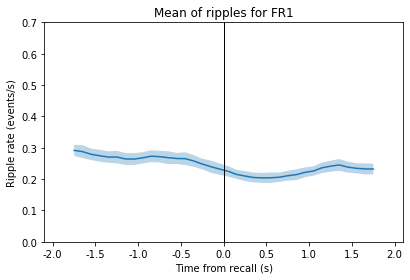

In [12]:
save_plot_data = 0

plot_sig_bars = 0 # orange signficance bars

# let's measure significance at two key 500 ms bins (and compare to similar bin 500 ms earlier/later)
stats_bin = 500 # time bin width in ms to test stats on

first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

start_array.shape
binned_first_stats_array = start_array[:,int((first_start-psth_start)/sr_factor):int((first_end-psth_start)/sr_factor)]
binned_second_stats_array = start_array[:,int((second_start-psth_start)/sr_factor):int((second_end-psth_start)/sr_factor)]
binned_first_stats_array = binBinaryArray(binned_first_stats_array,stats_bin,sr_factor)
binned_second_stats_array = binBinaryArray(binned_second_stats_array,stats_bin,sr_factor)
print('done binning start_arrays'); binned_start_array.shape

bin_model1 = MEstatsAcrossBins(binned_first_stats_array[:,[0,2]],subject_name_array,session_name_array)
bin_model2 = MEstatsAcrossBins(binned_second_stats_array[:,[0,2]],subject_name_array,session_name_array)
# bin_model1.summary()
# bin_model2.summary()


## plot PSTH and save data for plot (see SWRplots)


subplots(1,1,figsize=(6,4))
xr = bin_centers #np.arange(psth_start,psth_end,binsize)

# plot smoothed mean +/- SE
if pad > 0:
    plot(xr[pad:-pad],PSTH[pad:-pad])
    fill_between(xr[pad:-pad], PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3)
else:
    plot(xr,PSTH)
    fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:], alpha = 0.3)

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
if selected_period == 'surrounding_recall':
    xlabel('Time from recall (s)')
elif selected_period == 'math_retrieval':    
    xlabel('Time from response (s)')
elif selected_period == 'math':
    xlabel('Time from problem onset (s)')
ylabel('Ripple rate (events/s)')
title('Mean of ripples for '+exp)
tight_layout()
ax = plt.gca()
if filter_type == 'hamming':
    ylim = 0.7 # keep it here since occasionally CIs get kinda high
else:
    ylim = 0.45
ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0));
x_width = [ax.get_xlim()[0],ax.get_xlim()[1]]

# plot bands of significance
if plot_sig_bars == 1:
    if bin_model1.pvalues[1] < 0.05:
        plot([first_end-stats_bin,first_end],[0.2,0.2],color=(1,0.5,0))
    if bin_model2.pvalues[1] < 0.05:
        plot([second_start,second_start+stats_bin],[0.2,0.2],color=(1,0.5,0))
num_trials = start_array.shape[0]


# get directories for if you save (don't put this in save_plot_data below since want p-values printed at bottom close to figures)
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
path_name = '/home1/efegghi/SWR/figures/'+subfolder

fn = os.path.join(path_name,
    'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                  '_'+filter_type+'_'+sub_selection+'-ANLIPLOT.p') # -GT_5000.p' # -LT_5000.p' #'-intrusions.p'
print(fn)
print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
print('Test 2 p-value: '+str(bin_model2.pvalues[1]))
print(str(num_trials)+' recalls')

if save_plot_data == 1:
    # get strings for path name for save and loading cluster data

    if os.path.isdir(path_name) == False:
        os.mkdir(path_name)
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    with open(fn,'wb') as f:
        pickle.dump({'bin_centers':bin_centers,'PSTH':PSTH,'SE_plot':SE_plot,'num_trials':num_trials,
                    'bin_model1':bin_model1,'bin_model2':bin_model2,
                    'binned_first_stats_array':binned_first_stats_array,'binned_second_stats_array':binned_second_stats_array,
                    'subject_name_array':subject_name_array,'session_name_array':session_name_array,
                    'electrode_array':electrode_array,'channel_coords_array':channel_coords_array}, f)
a=1;

# Once you've saved recall_type 4 and 6 for all 3 algorithms, plot them!

/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_HPC_ca1_4_soz_in_hamming_whole-ANLIPLOT.p
Number of subjects: 87
Number of sessions: 177
Number of electrodes: 235
1st recalls: 10279 recalls
Test 1 p-value: 0.30184389288165125
Test 2 p-value: 0.006400105388294532
/home1/john/SWR/figures/NOTFIRSTRECALLS/SWR_FR1_HPC_ca1_6_soz_in_hamming_whole-ANLIPLOT.p
≥2nd recalls: 13831 recalls
Test 1 p-value: 1.8517756663532368e-21
Test 2 p-value: 0.0003443159418472796
/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_HPC_ca1_4_soz_in_butter_whole-ANLIPLOT.p
Number of subjects: 85
Number of sessions: 174
Number of electrodes: 231
1st recalls: 10185 recalls
Test 1 p-value: 0.09979721939886126
Test 2 p-value: 0.004003078937779833
/home1/john/SWR/figures/NOTFIRSTRECALLS/SWR_FR1_HPC_ca1_6_soz_in_butter_whole-ANLIPLOT.p
≥2nd recalls: 13831 recalls
Test 1 p-value: 2.0219528864056693e-14
Test 2 p-value: 0.002043080062610104
/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_HPC_ca1_4_soz_in_staresina_whole-ANLIPLOT.p
Number 

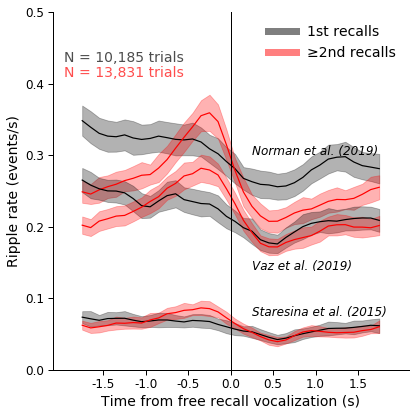

In [13]:
# load data from each

save_plot = 0

selected_period = 'surrounding_recall' 
remove_soz_ictal = False
sub_selection = 'whole' # 'second_half', 'whole' ,'first_half'

region_name = 'HPC' # 'ENT' # 'PHC' #'HPC'
location_selected = 'ca1' # 'dg' 'ca1' ''
extra = '-ANLIPLOT' #'-GT_5000' # '-LT_5000' # '' # '-GT_5000' # LT 5000 and GT 5000 are control analyses 
# for first 5000 ms of retrieval period or not

recall_minimum = 2000
pad = 2
psth_start = -2000
psth_end = 2000
stats_bin = 500 # time bin width in ms to test stats on
first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

set_pubfig()

for filter_type in ['hamming','butter','staresina']:
    
    for p,recall_type_switch in enumerate([4,6]):

        # get strings for path name for save and loading cluster data
        soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

        if ((p==0)&(filter_type == 'hamming')):
            subplots(1,1,figsize=(6,6)); ax = plt.gca()           
        if p == 0:
            color = (0,0,0)
            label = '1st recalls'
            line_dist = 0.175
        else:
            label = '≥2nd recalls'
            line_dist = 0.15
            if location_selected == 'ca1':
                color = (1,0,0)
#             elif location_selected == 'dg':
#                 color = (1,0,0)
#             elif ((location_selected == 'ca1dg') | (location_selected == '')):
#                 color = (0.5,0,0.5)
#             elif region_name == 'PHC':
#                 color = (0,0.5,0.5)
#             elif region_name == 'ENT':
#                 color = (0.5,0.5,0)

        path_name = '/home1/john/SWR/figures/'+subfolder
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                          '_'+filter_type+'_'+sub_selection+extra+'.p')   
        print(fn)
        with open(fn,'rb') as f:
            dat = pickle.load(f)
            bin_centers = dat['bin_centers']; PSTH = dat['PSTH']; SE_plot = dat['SE_plot']; num_trials = dat['num_trials'];
            bin_model1 = dat['bin_model1']; bin_model2 = dat['bin_model2']
            binned_first_stats_array = dat['binned_first_stats_array']; binned_second_stats_array = dat['binned_second_stats_array'];
            subject_name_array = dat['subject_name_array']; session_name_array = dat['session_name_array'];
            electrode_array = dat['electrode_array']
            
        if p == 0:
            print('Number of subjects: '+str(len(np.unique(subject_name_array))))
            print('Number of sessions: '+str(len(np.unique(session_name_array))))   
            subject_channel_array = []
            for i_session in range(len(session_name_array)):
                subject_channel_array.append(subject_name_array[i_session]+electrode_array[i_session])
            print('Number of electrodes: '+str(len(np.unique(subject_channel_array)))) 

        # make plot
        xr = bin_centers #np.arange(psth_start,psth_end,binsize)

        # plot smoothed mean +/- CI
        if pad > 0:
            SE_plot = fixSEgaps(SE_plot) # fix gaps when using 40% of data

            plot(xr[pad:-pad],PSTH[pad:-pad],color=color)
            fill_between(xr[pad:-pad], PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:],
                         color=color, alpha = 0.3, label='_nolegend_')
        else:
            plot(xr,PSTH)
            fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:],
                         color=color, alpha = 0.3, label='_nolegend_')

    #     # plot bands of significance
    #     if bin_model1.pvalues[1] < 0.05:
    #         plot([first_end-stats_bin,first_end],[line_dist,line_dist],'--',
    #              color=color,label='_nolegend_')
    #     if bin_model2.pvalues[1] < 0.05:
    #         plot([second_start,second_start+stats_bin],[line_dist,line_dist],'--',
    #              color=color,label='_nolegend_')
        print(label+': '+str(num_trials)+' recalls')
        print('Test 1 p-value: '+str(bin_model1.pvalues[1]))       
        print('Test 2 p-value: '+str(bin_model2.pvalues[1]))


xlabel('Time from free recall vocalization (s)')
ylabel('Ripple rate (events/s)')
# if filter_type == 'hamming':
ylim = 0.5 # keep it here since occasionally CIs get kinda high
#     plot([ax.get_xlim()[0],ax.get_xlim()[1]],[0.35,0.35],linewidth=1,linestyle='--',color=(0.8,0.8,0.8),label='_nolegend_')
# else: # for Vaz and hamming125200
#     ylim = 0.45

ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0),label='_nolegend_')

# recent changes suggested by Mike
label_start = -1500; label_end = 1500
xticks(np.arange(label_start,label_end+1,500),np.arange(label_start/1000,label_end/1000+1,500/1000),fontsize=12)
yticks(fontsize=12)
leg = ax.legend(['1st recalls','≥2nd recalls'],frameon=False,prop={'size': 14})
for legobj in leg.legendHandles:
    legobj.set_linewidth(7.0)
    legobj.set_alpha(0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

text(250,0.3,'Norman et al. (2019)',style='italic', fontsize=12)
text(250,0.14,'Vaz et al. (2019)',style='italic', fontsize=12)
text(250,0.0755,'Staresina et al. (2015)',style='italic', fontsize=12)
text(-1970,0.43,'N = 10,185 trials',color=(0.3,0.3,0.3))
text(-1970,0.41,'N = 13,831 trials',color=(1,.3,.3))

# if location_selected == '':
#     title(region_name)
# else:
#     title(location_selected)
tight_layout()

if save_plot == 1:
    plt.savefig('../figures/PSTHplots/'+exp+'_'+'PSTH_by_region-'+region_name+'_'+location_selected+'-'+str(recall_type_switch)+'_'+
                filter_type+'_'+sub_selection+extra+'.pdf',transparent=True) 

a=1;

# do interaction stats

In [47]:
# do separate test of 1st v. ≥2nd

import statsmodels.formula.api as smf

region_name = 'HPC' # 'ENT' # 'PHC' #'HPC'
location_selected = 'ca1' # 'ca1', 'dg'; '' for 'ENT' or 'PHC'
remove_soz_ictal = False
selected_period = 'surrounding_recall'

sub_selection = 'whole' # 'second_half','whole'
extra = '-ANLIPLOT'

for filter_type in ['hamming','butter','staresina']:

    for test in [1,2]: # tests 1 and 2 are pre and post recall

        session_name = []
        subject_name = []
        ripple_rates = []
        recall_indicator = []
        bin_indicator = []

        for i_rec,recall_type_switch in enumerate([4,6]):

            recall_minimum = 2000            
            soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

            path_name = '/home1/john/SWR/figures/'+subfolder
            fn = os.path.join(path_name,
                'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                              '_'+filter_type+'_'+sub_selection+extra+'.p')   
            print(fn)
            with open(fn,'rb') as f:
                dat = pickle.load(f)
                binned_first_stats_array = dat['binned_first_stats_array']; binned_second_stats_array = dat['binned_second_stats_array']
                subject_name_array = dat['subject_name_array']; session_name_array = dat['session_name_array']

                for i_bin,bn in enumerate([0,2]): # for test 1, 1 second before v. key bin; for test 2, key bin v. 1 second after

                    recall_indicator.extend(np.tile(i_rec,len(session_name_array)))
                    bin_indicator.extend(np.tile(i_bin,len(session_name_array)))
                    session_name.extend(session_name_array)
                    subject_name.extend(subject_name_array)
                    # remember, the binned_stats_arrays are 500 ms each from -1600:-100 or 200:1700 ms
                    if test == 1:
                        ripple_rates.extend(binned_first_stats_array[:,bn])
                    else:
                        ripple_rates.extend(binned_second_stats_array[:,2-bn])

        bin_df = pd.DataFrame(data={'session':session_name,'subject':subject_name,'bin_indicator':bin_indicator,
                                    'recall_indicator':recall_indicator,'ripple_rates':ripple_rates})
        vc = {'session':'0+session'}
        model_setup = smf.mixedlm("ripple_rates ~ bin_indicator*recall_indicator",
                                    bin_df, groups="subject", vc_formula=vc, re_formula='bin_indicator*recall_indicator')

    #     bin_model = model_setup.fit(reml=True,method='powell') # shouldn't use this--it doesnt seem to converge for all the coefficients
        bin_model = model_setup.fit(reml=True,method='nm',maxiter=2000) # works for PHC, whole

        if test == 1:
            print(bin_model.summary())
            print('Test 1 interaction p-value: '+str(bin_model.pvalues[3]))
            print('Test 1 t-value: '+str(bin_model.tvalues[3]))             
        else:
            print('Test 2 interaction p-value: '+str(bin_model.pvalues[3]))

/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_HPC_ca1_4_soz_in_hamming_whole-ANLIPLOT.p
/home1/john/SWR/figures/NOTFIRSTRECALLS/SWR_FR1_HPC_ca1_6_soz_in_hamming_whole-ANLIPLOT.p


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


                             Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             ripple_rates
No. Observations:               48032               Method:                         REML        
No. Groups:                     85                  Scale:                          0.6651      
Min. group size:                18                  Likelihood:                     -58507.3328 
Max. group size:                8802                Converged:                      Yes         
Mean group size:                565.1                                                           
------------------------------------------------------------------------------------------------
                                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------
Intercept                                              0.292

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Test 2 interaction p-value: 0.629911116431662
/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_HPC_ca1_4_soz_in_butter_whole-ANLIPLOT.p
/home1/john/SWR/figures/NOTFIRSTRECALLS/SWR_FR1_HPC_ca1_6_soz_in_butter_whole-ANLIPLOT.p


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


                             Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             ripple_rates
No. Observations:               48032               Method:                         REML        
No. Groups:                     85                  Scale:                          0.5034      
Min. group size:                18                  Likelihood:                     -51761.4368 
Max. group size:                8802                Converged:                      Yes         
Mean group size:                565.1                                                           
------------------------------------------------------------------------------------------------
                                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------
Intercept                                              0.246

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Test 2 interaction p-value: 0.6070648149062623
/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_HPC_ca1_4_soz_in_staresina_whole-ANLIPLOT.p
/home1/john/SWR/figures/NOTFIRSTRECALLS/SWR_FR1_HPC_ca1_6_soz_in_staresina_whole-ANLIPLOT.p


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                             Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             ripple_rates
No. Observations:               48032               Method:                         REML        
No. Groups:                     85                  Scale:                          0.1496      
Min. group size:                18                  Likelihood:                     -22572.6894 
Max. group size:                8802                Converged:                      Yes         
Mean group size:                565.1                                                           
------------------------------------------------------------------------------------------------
                                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------
Intercept                                              0.071

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
 

Test 2 interaction p-value: 0.741280449716196


# Do non-interaction (just comparison of 1st v 2nd)

In [50]:
# do separate test of 1st v. ≥2nd

import statsmodels.formula.api as smf

region_name = 'HPC' # 'ENT' # 'PHC' #'HPC'
location_selected = 'ca1' # 'ca1', 'dg'; '' for 'ENT' or 'PHC'
remove_soz_ictal = False
selected_period = 'surrounding_recall'

sub_selection = 'whole' # 'second_half','whole'
extra = '-ANLIPLOT'

for filter_type in ['hamming','butter','staresina']:

    for test in [1,2]: # tests 1 and 2 are pre and post recall

        session_name = []
        subject_name = []
        ripple_rates = []
        recall_indicator = []
        bin_indicator = []

        for i_rec,recall_type_switch in enumerate([4,6]):

            recall_minimum = 2000            
            soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

            path_name = '/home1/john/SWR/figures/'+subfolder
            fn = os.path.join(path_name,
                'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                              '_'+filter_type+'_'+sub_selection+extra+'.p')   
            print(fn)
            with open(fn,'rb') as f:
                dat = pickle.load(f)
                binned_first_stats_array = dat['binned_first_stats_array']; binned_second_stats_array = dat['binned_second_stats_array']
                subject_name_array = dat['subject_name_array']; session_name_array = dat['session_name_array']

                for i_bin,bn in enumerate([2]):                
#                 for i_bin,bn in enumerate([0,2]): # for test 1, 1 second before v. key bin; for test 2, key bin v. 1 second after

                    recall_indicator.extend(np.tile(i_rec,len(session_name_array)))
                    bin_indicator.extend(np.tile(i_bin,len(session_name_array)))
                    session_name.extend(session_name_array)
                    subject_name.extend(subject_name_array)
                    # remember, the binned_stats_arrays are 500 ms each from -1600:-100 or 200:1700 ms
                    if test == 1:
                        ripple_rates.extend(binned_first_stats_array[:,bn])
                    else:
                        ripple_rates.extend(binned_second_stats_array[:,2-bn])

        bin_df = pd.DataFrame(data={'session':session_name,'subject':subject_name,'bin_indicator':bin_indicator,
                                    'recall_indicator':recall_indicator,'ripple_rates':ripple_rates})
        vc = {'session':'0+session'}
#         model_setup = smf.mixedlm("ripple_rates ~ bin_indicator*recall_indicator",
#                                     bin_df, groups="subject", vc_formula=vc, re_formula='bin_indicator*recall_indicator')
        # do simpler model
        model_setup = smf.mixedlm("ripple_rates ~ recall_indicator",
                                    bin_df, groups="subject", vc_formula=vc, re_formula='recall_indicator')

    #     bin_model = model_setup.fit(reml=True,method='powell') # shouldn't use this--it doesnt seem to converge for all the coefficients
        bin_model = model_setup.fit(reml=True,method='nm',maxiter=2000) # works for PHC, whole

        if test == 1:
            print(bin_model.summary())
            print('Test 1 p-value: '+str(bin_model.pvalues[1]))
            print('Test 1 t-value: '+str(bin_model.tvalues[1]))             
        else:
            print('Test 2 p-value: '+str(bin_model.pvalues[1]))

/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_HPC_ca1_4_soz_in_hamming_whole-ANLIPLOT.p
/home1/john/SWR/figures/NOTFIRSTRECALLS/SWR_FR1_HPC_ca1_6_soz_in_hamming_whole-ANLIPLOT.p


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      ripple_rates
No. Observations:      24016        Method:                  REML        
No. Groups:            85           Scale:                   0.7114      
Min. group size:       9            Likelihood:              -30089.4087 
Max. group size:       4401         Converged:               Yes         
Mean group size:       282.5                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.281    0.015 18.290 0.000  0.251  0.311
recall_indicator                0.079    0.018  4.371 0.000  0.043  0.114
subject Var                     0.008    0.007                           
subject x recall_indicator Cov -0.000    0.008          

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Test 2 p-value: 0.48047167081084363
/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_HPC_ca1_4_soz_in_butter_whole-ANLIPLOT.p
/home1/john/SWR/figures/NOTFIRSTRECALLS/SWR_FR1_HPC_ca1_6_soz_in_butter_whole-ANLIPLOT.p


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                 Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     ripple_rates
No. Observations:       24016       Method:                 REML        
No. Groups:             85          Scale:                  0.5393      
Min. group size:        9           Likelihood:             -26733.4411 
Max. group size:        4401        Converged:              Yes         
Mean group size:        282.5                                           
------------------------------------------------------------------------
                               Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.231    0.011 21.626 0.000  0.210  0.252
recall_indicator               0.048    0.014  3.458 0.001  0.021  0.076
subject Var                    0.002    0.002                           
subject x recall_indicator Cov 0.000    0.002                        

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Test 2 p-value: 0.3228611436779738
/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_HPC_ca1_4_soz_in_staresina_whole-ANLIPLOT.p
/home1/john/SWR/figures/NOTFIRSTRECALLS/SWR_FR1_HPC_ca1_6_soz_in_staresina_whole-ANLIPLOT.p


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                 Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     ripple_rates
No. Observations:       24016       Method:                 REML        
No. Groups:             85          Scale:                  0.1612      
Min. group size:        9           Likelihood:             -12191.6623 
Max. group size:        4401        Converged:              Yes         
Mean group size:        282.5                                           
------------------------------------------------------------------------
                               Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.065    0.005 14.131 0.000  0.056  0.074
recall_indicator               0.021    0.007  3.176 0.001  0.008  0.034
subject Var                    0.000    0.001                           
subject x recall_indicator Cov 0.000    0.001                        

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
 